In [94]:
import numpy as np
import paddle 
from paddle.vision import MNIST,Cifar10
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import itertools

In [163]:
cifar10_train = Cifar10(
    mode= 'train',
    backend="cv2"   # 指定要返回的图像类型：PIL.Image 或 numpy.ndarray。必须是 {'pil'，'cv2'} 中的值
)

mnist_train = MNIST(
    mode= 'train',
    backend="cv2" 
)

In [8]:
print(type(cifar10_train),len(cifar10_train))
for img, label in itertools.islice(iter(cifar10_train), 1):
    print(type(img),img.shape,label)

<class 'paddle.vision.datasets.cifar.Cifar10'> 50000
<class 'numpy.ndarray'> (32, 32, 3) 6


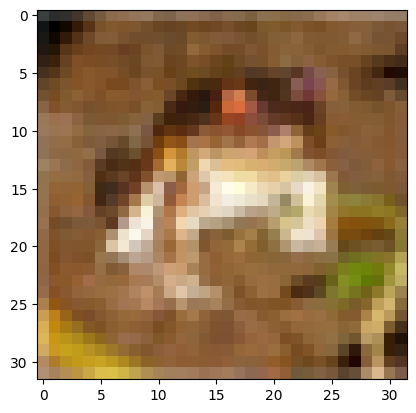

In [218]:
img0,label0 = cifar10_train[0]
plt.imshow(img0/255)

In [219]:
type(img0)
print(img0.shape)

(32, 32, 3)


# SVD: Singular Value Decomposition 

In [223]:
#Creating a matrix A
A = img0[:,:,0]

#Performing SVD
U, D, VT = np.linalg.svd(A)

#Checking if we can remake the original matrix using U,D,VT
A_remake = (U @ np.diag(D) @ VT)
print(A_remake)

[[ 5.89999886e+01  4.30000000e+01  5.00000114e+01 ...  1.58000015e+02
   1.52000015e+02  1.47999985e+02]
 [ 1.59999962e+01 -1.90734863e-06  1.80000000e+01 ...  1.23000000e+02
   1.18999992e+02  1.22000000e+02]
 [ 2.50000000e+01  1.59999924e+01  4.89999771e+01 ...  1.17999992e+02
   1.19999992e+02  1.09000000e+02]
 ...
 [ 2.08000000e+02  2.01000046e+02  1.98000015e+02 ...  1.60000000e+02
   5.60000000e+01  5.29999962e+01]
 [ 1.80000000e+02  1.72999969e+02  1.85999985e+02 ...  1.84000031e+02
   9.69999924e+01  8.30000000e+01]
 [ 1.77000015e+02  1.68000000e+02  1.78999985e+02 ...  2.16000000e+02
   1.51000000e+02  1.22999985e+02]]


In [224]:
U

array([[-0.16039349, -0.04298889, -0.28180057, ...,  0.27340555,
        -0.18639733,  0.12015267],
       [-0.13156171, -0.06434204, -0.30179253, ..., -0.3577705 ,
         0.10971635, -0.00184295],
       [-0.13908677, -0.06305245, -0.22112073, ...,  0.2912994 ,
        -0.02262908, -0.07094591],
       ...,
       [-0.17466223,  0.19764264,  0.27234548, ...,  0.33125415,
         0.17923367, -0.3252645 ],
       [-0.1743581 ,  0.26224923,  0.17619374, ..., -0.31664214,
        -0.15345293,  0.30745035],
       [-0.19688973,  0.29160854,  0.04094113, ...,  0.21575458,
        -0.02305492, -0.2622688 ]], dtype=float32)

In [225]:
D

array([4.5857036e+03, 5.9184833e+02, 4.5860385e+02, 3.6927002e+02,
       3.5221051e+02, 2.7271332e+02, 2.3411714e+02, 1.9596532e+02,
       1.7263036e+02, 1.3387161e+02, 1.1473769e+02, 9.3608749e+01,
       8.3938133e+01, 6.3526638e+01, 5.9778904e+01, 4.6615417e+01,
       4.5584438e+01, 3.4959564e+01, 2.9619411e+01, 2.7163990e+01,
       2.4222549e+01, 1.9372572e+01, 1.7909872e+01, 1.5606694e+01,
       1.3020308e+01, 1.0694430e+01, 8.3094330e+00, 6.5600958e+00,
       4.1188755e+00, 2.8546269e+00, 2.3156307e+00, 7.3062885e-01],
      dtype=float32)

In [226]:
VT

array([[-0.17111059, -0.16064821, -0.16460638, ..., -0.16952205,
        -0.1547326 , -0.14796048],
       [ 0.2205256 ,  0.20662247,  0.20296153, ...,  0.18621142,
         0.05114086, -0.00992778],
       [ 0.34360695,  0.3862748 ,  0.2948675 , ...,  0.10824057,
        -0.10421443, -0.19234794],
       ...,
       [ 0.18712863, -0.08435281, -0.34301826, ...,  0.1236167 ,
        -0.137693  ,  0.19956212],
       [ 0.20673457, -0.26916468,  0.3507681 , ..., -0.19824922,
         0.10762598, -0.01174179],
       [ 0.25026307, -0.34337574,  0.09639948, ...,  0.323235  ,
        -0.14532012, -0.10398368]], dtype=float32)

In [227]:
def svd_compression(img, k):
    # img.shape = (28,28,1)
    svd_image = np.zeros_like(img)
    for i in range(img.shape[2]):
        # 进行奇异值分解, 从svd函数中得到的奇异值sigma 是从大到小排列的
        U, Sigma, VT = np.linalg.svd(img[:,:,i])
        img_remake = (U @ np.diag(D) @ VT)
        if (img_remake == img[:, :, i]).any():
            "we can't remake the original matrix using U,D,VT"
        svd_image[:, :, i] = U[:,:k].dot(np.diag(Sigma[:k])).dot(VT[:k,:])
 
    return svd_image

In [228]:
def sample_radial(x0, k, epsilon):
    """
    根据概率密度函数Dϵ,k(x0)(x)对径向坐标进行采样
    """
    def objective_func(r):
        return np.exp(-epsilon * r) - np.random.uniform(0, 1)

    r0 = np.linalg.norm(x0)
    r = fsolve(objective_func, r0)[0]

    return r

def sample_angular(k):
    """
    在单位(k-1)-球面上均匀采样一个点
    """
    angles = np.random.uniform(0, 2 * np.pi, k - 1)
    a = np.concatenate([np.cos(angles), [np.sin(angles[-1])]])
    for i in range(len(a) - 2, -1, -1):
        a[i] *= np.sin(angles[i])
    return a

In [256]:
def private_sampling(img,k,epsilon):
    """
    实现随机采样机制
    """
    # img.shape = (28,28,1)
    sampling_image = np.zeros_like(img)
    for i in range(img.shape[2]):
        # 进行奇异值分解, 从svd函数中得到的奇异值sigma 是从大到小排列的
        U, Sigma, VT = np.linalg.svd(img[:,:,i])
        img_remake = (U @ np.diag(D) @ VT)
        if (img_remake == img[:, :, i]).any():
            "we can't remake the original matrix using U,D,VT"
        
        r = sample_radial(Sigma, k, epsilon)
        a = sample_angular(k)
        x = r * a
        
        sampling_image[:, :, i] = U[:,:k].dot(np.diag(x)).dot(VT[:k,:])

    return np.clip(sampling_image,0,255)

In [257]:
svd_image = svd_compression(img0,k = 4)
sampling_image = private_sampling(img0,k = 4, epsilon = 0.5)

C:\Users\34538\AppData\Local\Temp\ipykernel_8620\3144225102.py:9: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  r = fsolve(objective_func, r0)[0]


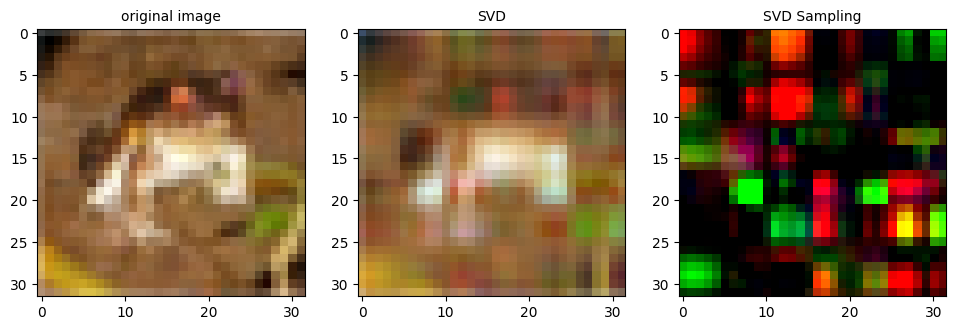

In [258]:
fig = plt.figure(figsize=(20,20)) 
ax1 = fig.add_subplot(1, 5, 1)  # 2行1列，第1个位置  
plt.title('original image',fontsize=10)
ax1.imshow(img0/255.0,cmap='gray')

ax2 = fig.add_subplot(1, 5, 2)
plt.title('SVD',fontsize=10)
ax2.imshow(svd_image/255.0,cmap='gray')

ax2 = fig.add_subplot(1, 5, 3)
plt.title('SVD Sampling',fontsize=10)
ax2.imshow(sampling_image/255.0,cmap='gray')